In [1]:
import numpy as np
import sys
import copy
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from threading import Thread
from time import sleep
import datetime

In [2]:
np.set_printoptions( threshold = sys.maxsize )

In [3]:
class XY:
    def __init__( self, x_ = 0, y_ = 0 ):
        self.x = x_
        self.y = y_
    def __str__( self ):
        return ( '( x: ' + str( self.x ) + ', y: ' + str( self.y ) + ' )' )

class Object2D:
    def __init__( self, sizeX_, sizeY_, pattern_ ):
        self.sizeX = sizeX_
        self.sizeY = sizeY_
        self.pattern = pattern_

In [4]:
class Mesh( Object2D ):
    def __init__( self, sizeX_, sizeY_, pattern_ ):
        super().__init__( sizeX_, sizeY_, pattern_ )
    def Copy( self ):
        return Mesh( self.sizeX, self.sizeY, copy.deepcopy( self.pattern ) )
    def Scale( self, xScale, yScale ):
        return self
    def AddMass( self, mass ):
        for x in range( len( self.pattern ) ):
            for y in range( len( x ) ):
                self.pattern[ x ][ y ] *= mass
        return self
    def ToMass( self, x, y ):
        return Mass( x, y, self )

In [5]:
class Planet( Mesh ):
    def __init__( self, radius_, distributedMass_, default_ = 0.0, ringDistance_ = 0.0, ringDepth_ = 0.0, increment = .01 ):
        self.radius = radius_
        self.ringDistance = ringDistance_
        self.default = default_
        self.ringDepth = ringDepth_
        self.ModifyMass( distributedMass_ )
        self.FillPlanet( self.radius, True, increment )
    def ModifyMass( self, distributedMass_ ):
        self.distributedMass = distributedMass_
        self.mass = ( 2.0 * np.pi * ( self.radius * self.radius ) ) * self.distributedMass
        return self
    def ChangeRadius( self, radius_, fillRing, increment = .01, ):
        self.FillPlanet( radius_, fillRing, increment )
        return self
    def FillPlanet( self, radius_, doFillRing = True, increment = .01, distributedMass_ = None ):
        trueRadius = int( self.radius + self.ringDistance + self.ringDepth ) * 2
        self.radius = radius_
        self.sizeX = trueRadius
        self.sizeY = trueRadius
        planet = []
        if distributedMass_ != None:
            self.ModifyMass( distributedMass_ )
        for i in range( self.sizeX ):
            planet.append( [ self.default ] * self.sizeY )
        for i in range( int( radius_ ) ):
            currentRadius = radius_ - i
            theta = 0.0
            while theta <= ( 2.0 * np.pi ):
                planet[ 
                    ( int( currentRadius ) - int( np.sin( theta ) * currentRadius ) ) + 
                    int( ( self.sizeX / 2.0 ) - ( currentRadius ) ) ][ int( currentRadius ) - 
                    int( np.cos( theta ) * currentRadius ) + 
                    int( ( self.sizeY / 2.0 ) - ( currentRadius ) ) ] = self.distributedMass
                theta += increment
        self.pattern = planet
        if doFillRing == True:
            self.FillRing( self.ringDistance, self.ringDepth, increment )
        return self
    
    def FillRing( self, ringDistance_ = None, ringDepth_ = None, increment = .01, fillPlanet = False ):
        if ringDistance_ == None:
            ringDistance_ = self.ringDistance
        else:
            self.ringDistance = ringDistance_
        if ringDepth_ == None:
            ringDepth_ = self.ringDepth
        else:
            self.ringDepth = ringDepth_
        trueRadius = int( self.radius + ringDistance_ + ringDepth_ ) * 2
        for i in range( int( ringDepth_ ) ):
            theta = 0.0
            while theta <= ( 2.0 * np.pi ):
                self.pattern[ 
                    ( int( i ) - int( np.sin( theta ) * ( ringDistance_ + self.radius + i ) ) ) + 
                    int( ( self.sizeX / 2.0 ) - ( i ) ) ][ int( i ) - 
                    int( np.cos( theta ) * ( ringDistance_ + self.radius + i ) ) + 
                    int( ( self.sizeY / 2.0 ) - ( i ) ) ] = self.distributedMass
                theta += increment
        return self

In [6]:
class Mass( Object2D ):
    def __init__( self, x_, y_, mesh, noDeepCopy = False ):
        if noDeepCopy == False:
            super().__init__( mesh.sizeX, mesh.sizeY, copy.deepcopy( mesh.pattern ) )
        else:
            super().__init__( mesh.sizeX, mesh.sizeY, mesh.pattern )
        self.x = x_
        self.y = y_
    def ToMesh( self ):
        return Mesh( self.sizeX, self.sizeY, copy.deepcopy( self.pattern ) )
    def Copy( self ):
        return Mass( self.x, self.y, self.ToMesh(), True )

In [187]:
class GravitySimulationFeild:
    def __init__( self, size, boundry_, default_ = 0, phi_ = [], masses_ = [], vectorFeild_ = [] ):
        self.phi = phi_
        self.vectorFeild = vectorFeild_
        self.masses = masses_
        self.boundry = boundry_
        self.default = default_
        if len( self.phi ) == 0:
            self.CreatePhi( size ).CreateBoundry( self.boundry ).SetDefault( self.default )
        if len( self.vectorFeild ) == 0:
            self.vectorFeild = self.CreateZero2DVectors( size )
        self.size = size
    def MakeObject( self, mesh, x, y ):
        self.masses.append( mesh.ToMass( x, y ) )
        return self
    def AddMass( self, mass ):
        self.masses.append( mass )
        return self
    def CreateZeros( self, size ):
        return np.zeros( [ size + 1, size + 1 ] )
    def CreateZero2DVectors( self, size ):
        building = [ [ XY() ] * ( size + 1 ) ] * ( size + 1 )
        for i in range( len( building ) ):
            for j in range( len( building[ i ] ) ):
                building[ i ][ j ] = XY()
        return building
    def CreatePhi( self, size ):
        self.phi = self.CreateZeros( size )
        #Fluid A.P.I
        return self
    def CreateBoundry( self, boundry ):
        size = len( self.phi ) - 1
        for i in range( size ):
            self.phi[ i ][ 0 ] = boundry
            self.phi[ 0 ][ i ] = boundry
            self.phi[ i ][ size ] = boundry
            self.phi[ size ][ i ] = boundry
        return self
    def SetDefault( self, default ):
        for i in range( 1, len( self.phi ) - 1 ):
            for j in range( 1, len( self.phi[ i ] ) - 1 ):
                self.phi[ i ][ j ] = default
        return self
    def AddMassesToFeild( self ):
        massfulPhi = copy.deepcopy( self.phi )
        for i in self.masses:
            for x in range( i.sizeX ):
                for y in range( i.sizeY ):
                    massfulPhi[ i.x + x ][ i.y + y ] = i.pattern[ x ][ y ]
        return GravitySimulationFeild( self.size, self.boundry, self.default, massfulPhi, copy.deepcopy( self.masses ), copy.deepcopy( self.vectorFeild ) )
    def CalculatePhi( self, maximumExecutions, noDeepCopy = False, xStart = 1, yStart = 1, xEnd_ = None, yEnd_ = None ):
        phiBase = self.phi
        vectorFeildBase = self.vectorFeild
        if xEnd_ == None:
            xEnd_ = self.size
            yEnd_ = self.size
        if noDeepCopy == False:
            phiBase = copy.deepcopy( self.phi )
            vectorFeildBase = copy.deepcopy( self.vectorFeild )
        phiCalculate = self.CreateZeros( self.size )
        for execution in range( maximumExecutions ):
            for x in range( xStart, xEnd_ ):
                for y in range( yStart, yEnd_ ):
                    phiCalculate[ x ][ y ] = .25 * ( phiBase[ x + 1 ][ y ] + phiBase[ x - 1 ][ y ] + phiBase[ x ][ y + 1 ] + phiBase[ x ][ y - 1 ] )
            for i in range( xStart, xEnd_ ):
                for j in range( yStart, yEnd_ ):
                    phiBase[ i ][ j ] = phiCalculate[ i ][ j ]
                    if vectorFeildBase != self.vectorFeild:
                        vectorFeildBase[ i ][ j ][ 0 ] = self.vectorFeild[ i ][ j ][ 0 ]
                        vectorFeildBase[ i ][ j ][ 0 ] = self.vectorFeild[ i ][ j ][ 1 ]
        return GravitySimulationFeild( self.size, self.boundry, self.default, phiBase, copy.deepcopy( self.masses ), vectorFeildBase )
    def CalculateVectorFeild( self, maximumExecutions, noDeepCopy = False, xStart = 1, yStart = 1, xEnd_ = None, yEnd_ = None ):
        phiBase = self.phi
        vectorFeildBase = self.vectorFeild
        if xEnd_ == None:
            xEnd_ = self.size
            yEnd_ = self.size
        if noDeepCopy == False:
            phiBase = copy.deepcopy( self.phi )
            vectorFeildBase = copy.deepcopy( self.vectorFeild )
        vectorFeildCalculate = self.CreateZero2DVectors( self.size )
        for x in range( xStart, xEnd_ ):
            for y in range( yStart, yEnd_ ):
                #[i][j], gx = -(phi[i+1][j] - phi[i-1][j])/2
                #[ i ][ j ] gy = ( -( phi[ i ][ j + 1 ] - phi[ i ][ j - 1 ] ) / 2 )
                vectorFeildCalculate[ x ][ y ].x = ( -( self.phi[ x + 1 ][ y ] - self.phi[ x - 1 ][ y ] ) / 2.0 )
                vectorFeildCalculate[ x ][ y ].y = ( -( self.phi[ x ][ y + 1 ] - self.phi[ x ][ y - 1 ] ) / 2.0 )
        #for execution in range( maximumExecutions ):
        #    for x in range( xStart, xEnd_ ):
        #        for y in range( yStart, yEnd_ ):
        #            #[i][j], gx = -(phi[i+1][j] - phi[i-1][j])/2
        #            #[ i ][ j ] gy = ( -( phi[ i ][ j + 1 ] - phi[ i ][ j - 1 ] ) / 2 )
        #            vectorFeildCalculate[ x ][ y ].x = ( -( vectorFeildCalculate[ x + 1 ][ y ].x - vectorFeildCalculate[ x - 1 ][ y ].x ) / 2.0 )
        #            vectorFeildCalculate[ x ][ y ].y = ( -( vectorFeildCalculate[ x ][ y + 1 ].y - vectorFeildCalculate[ x ][ y - 1 ].y ) / 2.0 )
        for i in range( xStart, xEnd_ ):
            for j in range( yStart, yEnd_ ):
                vectorFeildBase[ i ][ j ].x = vectorFeildCalculate[ i ][ j ].x
                vectorFeildBase[ i ][ j ].y = vectorFeildCalculate[ i ][ j ].y
        return GravitySimulationFeild( self.size, self.boundry, self.default, phiBase, copy.deepcopy( self.masses ), vectorFeildBase )
    def Calculate( self, maximumExecutions, noDeepCopy = False, xStart = 1, yStart = 1, xEnd_ = None, yEnd_ = None ):
        return self.CalculatePhi( maximumExecutions, noDeepCopy, xStart, yStart, xEnd_, yEnd_ ).CalculateVectorFeild( maximumExecutions, noDeepCopy, xStart, yStart, xEnd_, yEnd_ )
    def MultiThreadedCalculate( self, amountOfThreads, executionDepth ):
        threadCopy = GravitySimulationFeild( self.size, self.boundry, self.default, copy.deepcopy( self.phi ), copy.deepcopy( self.masses ), copy.deepcopy( self.vectorFeild ) )
        segmentSize = threadCopy.size / amountOfThreads
        threads = []
        for i in range( amountOfThreads ):
            threads.append( Thread( target = threadCopy.Calculate, args = ( executionDepth, True, int( i * segmentSize ), 1, int( ( i + 1 ) * segmentSize ), threadCopy.size ) ) )
            threads[ -1 ].start()
        for i in threads:
            i.join()
        return threadCopy
    def DisplayVectorFeild( self, spacing = 10, blackAndWhite = False, normalize = True ):
        xPositions = self.CreateZeros( self.size )
        yPositions = self.CreateZeros( self.size )
        xDirections = self.CreateZeros( self.size )
        yDirections = self.CreateZeros( self.size )
        colors = self.CreateZeros( self.size )
        count = 0
        for i in range( len( xPositions ) ):
            for j in range( len( xPositions[ i ] ) ):
                if j % spacing == 0 and i % spacing == 0:
                    xPositions[ i ][ j ] = i
                    yPositions[ i ][ j ] = j
                    currentVector = self.vectorFeild[ i ][ j ]
                    magnitude = np.sqrt( ( ( currentVector.x * currentVector.x ) + 
                                          ( currentVector.y * currentVector.y ) ) )
                    xDirections[ i ][ j ] = self.vectorFeild[ i ][ j ].x
                    yDirections[ i ][ j ] = self.vectorFeild[ i ][ j ].y
                    if normalize == True:
                        if magnitude != 0.0:
                            xDirections[ i ][ j ] /= magnitude
                            yDirections[ i ][ j ] /= magnitude
                    colors[ i ][ j ] = magnitude * 256
        if blackAndWhite == False:
            plt.quiver( xPositions, yPositions, xDirections, yDirections, colors )
        else:
            plt.quiver( xPositions, yPositions, xDirections, yDirections )
        return self

In [188]:
g = GravitySimulationFeild( 200, -4.0, 3.0 )

In [189]:
p0 = Planet( 4, 100000000.0, 0.0 )

In [190]:
p1 = Planet( 5, 20000000.0, 0.0, 3, 1 )

In [191]:
p2 = Planet( 2, 50000000.0, 0.0, 4, 1 )

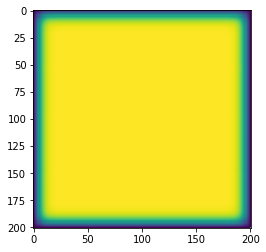

In [192]:
plt.imshow( g.MultiThreadedCalculate( 4, 100 ).phi )

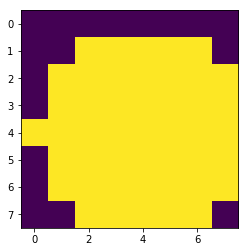

In [193]:
plt.imshow( p0.pattern )

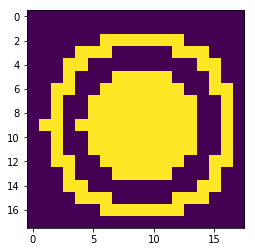

In [194]:
plt.imshow( p1.pattern )

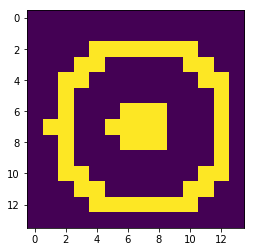

In [195]:
plt.imshow( p2.pattern )

In [196]:
g.AddMass( p0.ToMass( 150, 50 ) ).AddMass( p1.ToMass( 100, 100 ) ).AddMass( p2.ToMass( 50, 120 ) )

In [197]:
g0 = g.AddMassesToFeild()

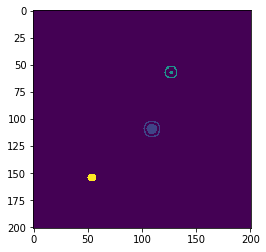

In [198]:
plt.imshow( g0.phi )

In [199]:
g1 = g.AddMassesToFeild().MultiThreadedCalculate( 4, 100 )

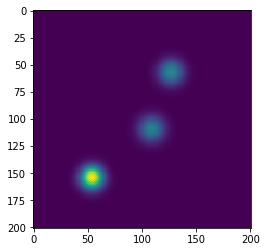

In [200]:
plt.imshow( g1.phi )

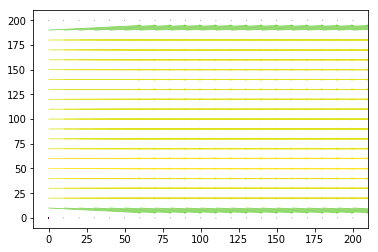

In [201]:
g1.DisplayVectorFeild( 10 )

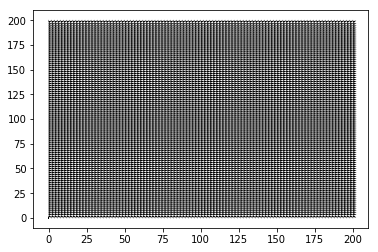

In [202]:
g1.DisplayVectorFeild( 2, True )

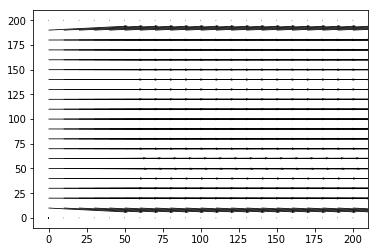

In [203]:
g1.DisplayVectorFeild( 10, True, False )